In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_16456\2519038489.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_16456\2519038489.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_16456\2519038489.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_16456\2519038489.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is depr

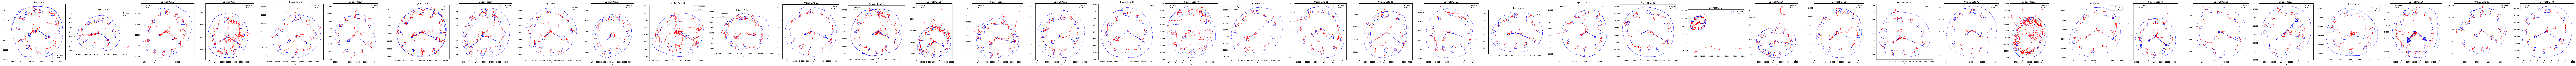

Processed data shape: (154688, 3)
Average number of data points: 3867


In [2]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler(feature_range=(-1, 1))  # Change range to (-1, 1)
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task6'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=40)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [3]:
# Cell 3 (modified)
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def call(self, x):
        return self.model(x)

class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(3,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(3, activation='tanh')  # Change to tanh
        ])
        self.discriminator = Discriminator()

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = decoded[:, :2]
        pen_status = tf.sigmoid(decoded[:, 2])  # Use sigmoid for pen_status
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar

In [4]:
# Cell 4 (modified)
def compute_loss(vaegan, x):
    x_reconstructed, mean, logvar = vaegan(x)
    
    # VAE Loss
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x[:, :2], x_reconstructed[:, :2]))
    pen_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 2], x_reconstructed[:, 2]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

    # GAN Loss
    real_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(vaegan.discriminator(x)), vaegan.discriminator(x)))
    fake_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(vaegan.discriminator(x_reconstructed)), vaegan.discriminator(x_reconstructed)))
    adversarial_loss = real_loss + fake_loss

    vae_loss = reconstruction_loss + pen_loss + vaegan.beta * kl_loss
    total_loss = vae_loss + adversarial_loss

    return total_loss, reconstruction_loss, kl_loss, adversarial_loss

latent_dim = 256
beta = 0.001  # Increased beta
learning_rate = 0.0005  # Reduced learning rate

vaegan = VAEGAN(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [5]:
# Cell 5 (modified)
@tf.function
def train_step(vaegan, x, optimizer):
    with tf.GradientTape() as tape:
        total_loss, reconstruction_loss, kl_loss, adversarial_loss = compute_loss(vaegan, x)
    gradients = tape.gradient(total_loss, vaegan.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vaegan.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss, adversarial_loss

batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 1
early_stopping_patience = 10
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
adversarial_loss_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    adversarial_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss, adversarial_loss = train_step(vaegan, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            adversarial_loss_sum += adversarial_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss),
                              'KL Loss': float(kl_loss), 'Adversarial Loss': float(adversarial_loss)})

    total_loss /= num_batches
    reconstruction_loss_avg = reconstruction_loss_sum / num_batches
    kl_loss_avg = kl_loss_sum / num_batches
    adversarial_loss_avg = adversarial_loss_sum / num_batches

    total_loss_history.append(total_loss)
    reconstruction_loss_history.append(reconstruction_loss_avg)
    kl_loss_history.append(kl_loss_avg)
    adversarial_loss_history.append(adversarial_loss_avg)

    print(f'Epoch {epoch+1}/{epochs}: Total Loss: {total_loss:.4f}, Reconstruction Loss: {reconstruction_loss_avg:.4f}, KL Loss: {kl_loss_avg:.4f}, Adversarial Loss: {adversarial_loss_avg:.4f}')

    if total_loss < best_loss - min_delta:
        best_loss = total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

Epoch 1/1:   0%|          | 0/605 [00:00<?, ?batch/s]

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vaegan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
Epoch 1/1: 100%|██████████| 605/605 [00:26<00:00, 22.56batch/s, Total Loss=0.317, Reconstruction Loss=0.00114, KL Loss=1.97, Adversarial Loss=0.000505] 

Epoch 1/1: Total Loss: 0.5885, Reconstruction Loss: 0.0885, KL Loss: 1.3599, Adversarial Loss: 0.1600


C:\Users\annek\AppData\Local\Temp\ipykernel_16456\1462381710.py:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


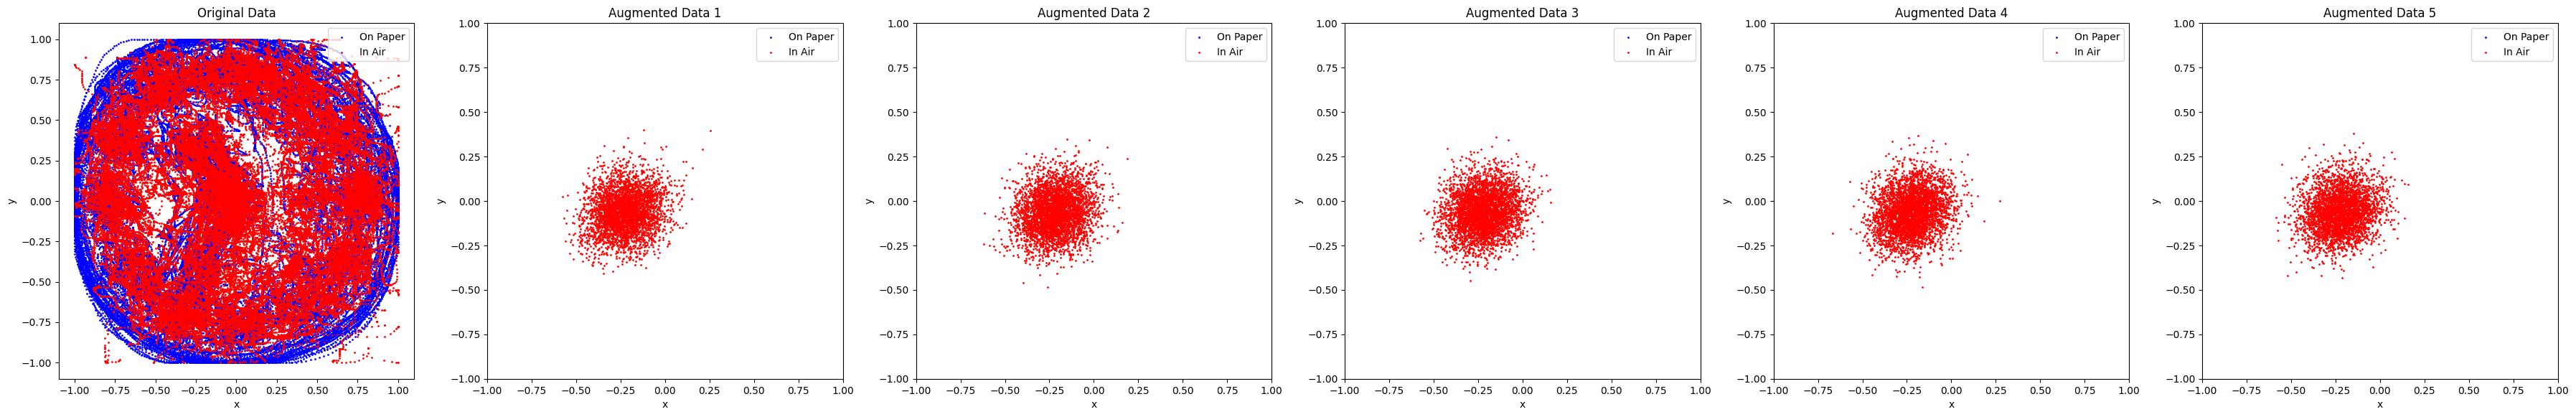

In [6]:
#Cell 6 (modified)
def generate_augmented_data_vaegan(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        # Generate random latent vectors
        z = tf.random.normal((avg_data_points, model.latent_dim))
        # Decode to generate augmented data
        augmented_data = model.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of data points
        if num_points < augmented_data.shape[0]:
            augmented_datasets.append(augmented_data[:num_points])
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_datasets.append(np.vstack([augmented_data, padding]))

    return augmented_datasets

# Generate augmented data using VAEGAN
num_augmented_files = 5  # Increased number of augmented files
augmented_datasets_vaegan = generate_augmented_data_vaegan(vaegan, num_augmented_files, avg_data_points)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6 * (num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 2] == 1]
original_in_air = combined_data[combined_data[:, 2] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = -1, 1  # Set to -1 and 1 due to new scaling
y_min, y_max = -1, 1  # Set to -1 and 1 due to new scaling

for i, augmented_data in enumerate(augmented_datasets_vaegan):
    augmented_on_paper = augmented_data[augmented_data[:, 2] > 0.5]
    augmented_in_air = augmented_data[augmented_data[:, 2] <= 0.5]
    axs[i + 1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i + 1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i + 1].set_title(f'Augmented Data {i + 1}')
    axs[i + 1].set_xlabel('x')
    axs[i + 1].set_ylabel('y')
    axs[i + 1].set_aspect('equal')
    axs[i + 1].set_xlim(x_min, x_max)
    axs[i + 1].set_ylim(y_min, y_max)
    axs[i + 1].legend()

plt.tight_layout()
plt.show()

In [7]:
# Cell 7 (modified)
def download_augmented_data(augmented_datasets, scalers, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler) in enumerate(zip(augmented_datasets, scalers)):
        # Inverse transform the x and y coordinates
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :2]),
            augmented_data[:, 2]
        ))
        
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

download_augmented_data(augmented_datasets_vaegan, scalers[:len(augmented_datasets_vaegan)])

Saved augmented_data\augmented_data_1.csv
Saved augmented_data\augmented_data_2.csv
Saved augmented_data\augmented_data_3.csv
Saved augmented_data\augmented_data_4.csv
Saved augmented_data\augmented_data_5.csv
